# Staining-based Segmentation

This notebook showcases end-to-end ssDNA staining-based cell segmentation. This is done in two broad steps.

1. Fix any mis-alignments between the staining image and RNA coordinates.
1. Label individual nuclei from the staining image.
2. (Optionally) Expand the nuclei labels to obtain cell labels.

Note that the second step is optional, as there is likely a tradeoff between cell purity (only using the nuclei ends up yielding purer single-cell RNA) and number of UMIs captured per cell (expanding the labels yields higher UMIs per cell).

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/home/lioscro/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/lioscro/miniconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/lioscro/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and opera

## Load the data

`st.io.read_bgi_agg` reads in aggregated UMI counts per pixel. By also providing the staining image as the second argument, the image is loaded into the returned AnnData as well.

In [2]:
adata = st.io.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz', 'data/SS200000135IL-D1.ssDNA.tif', scale=0.5, scale_unit='um')
adata

AnnData object with n_obs × n_vars = 2001 × 2001
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced'

## 1. Refine stain and RNA alignment

There may be minor mis-alignments between the staining image and RNA coordinates. This can be problematic when we are trying to group pixels based on the staining image. Therefore, we refine the alignment to make sure the coordinates are properly aligned. We do so in a couple of steps.

1. Obtain a nuclei mask from the staining image by using `st.pp.segmentation.mask_nuclei_from_stain`.
2. Bin pixels by RNA density with `st.pp.segmentation.segment_densities`, and obtain a nuclei mask from unspliced RNA signal by using `st.pp.segmentation.score_and_mask_pixels`.
3. Align these two masks with `st.pp.segmentation.refine_alignment`.

For reference, the `st.pp.segmentation.mask_nuclei_from_stain` performs the following steps.

1. Obtain a global background mask by applying a global thresholding technique using multi-class Otsu thresholding. Specifically, each pixel is classified into one of three bins, and we take all the pixels below the first threshold to be background.
2. Obtain a (noisy) nuclei mask by applying a local (adaptive) thresholding method, which uses the local neighborhood of each pixel to determine the threshold for that pixel. This method is usually accurate in nuclei-dense areas, but are noisy in sparse areas.
3. Take pixels that are not background (step 1) and are classified as nuclei (step 2) to be the nuclei mask.

### 1.1. Mask nuclei from stain

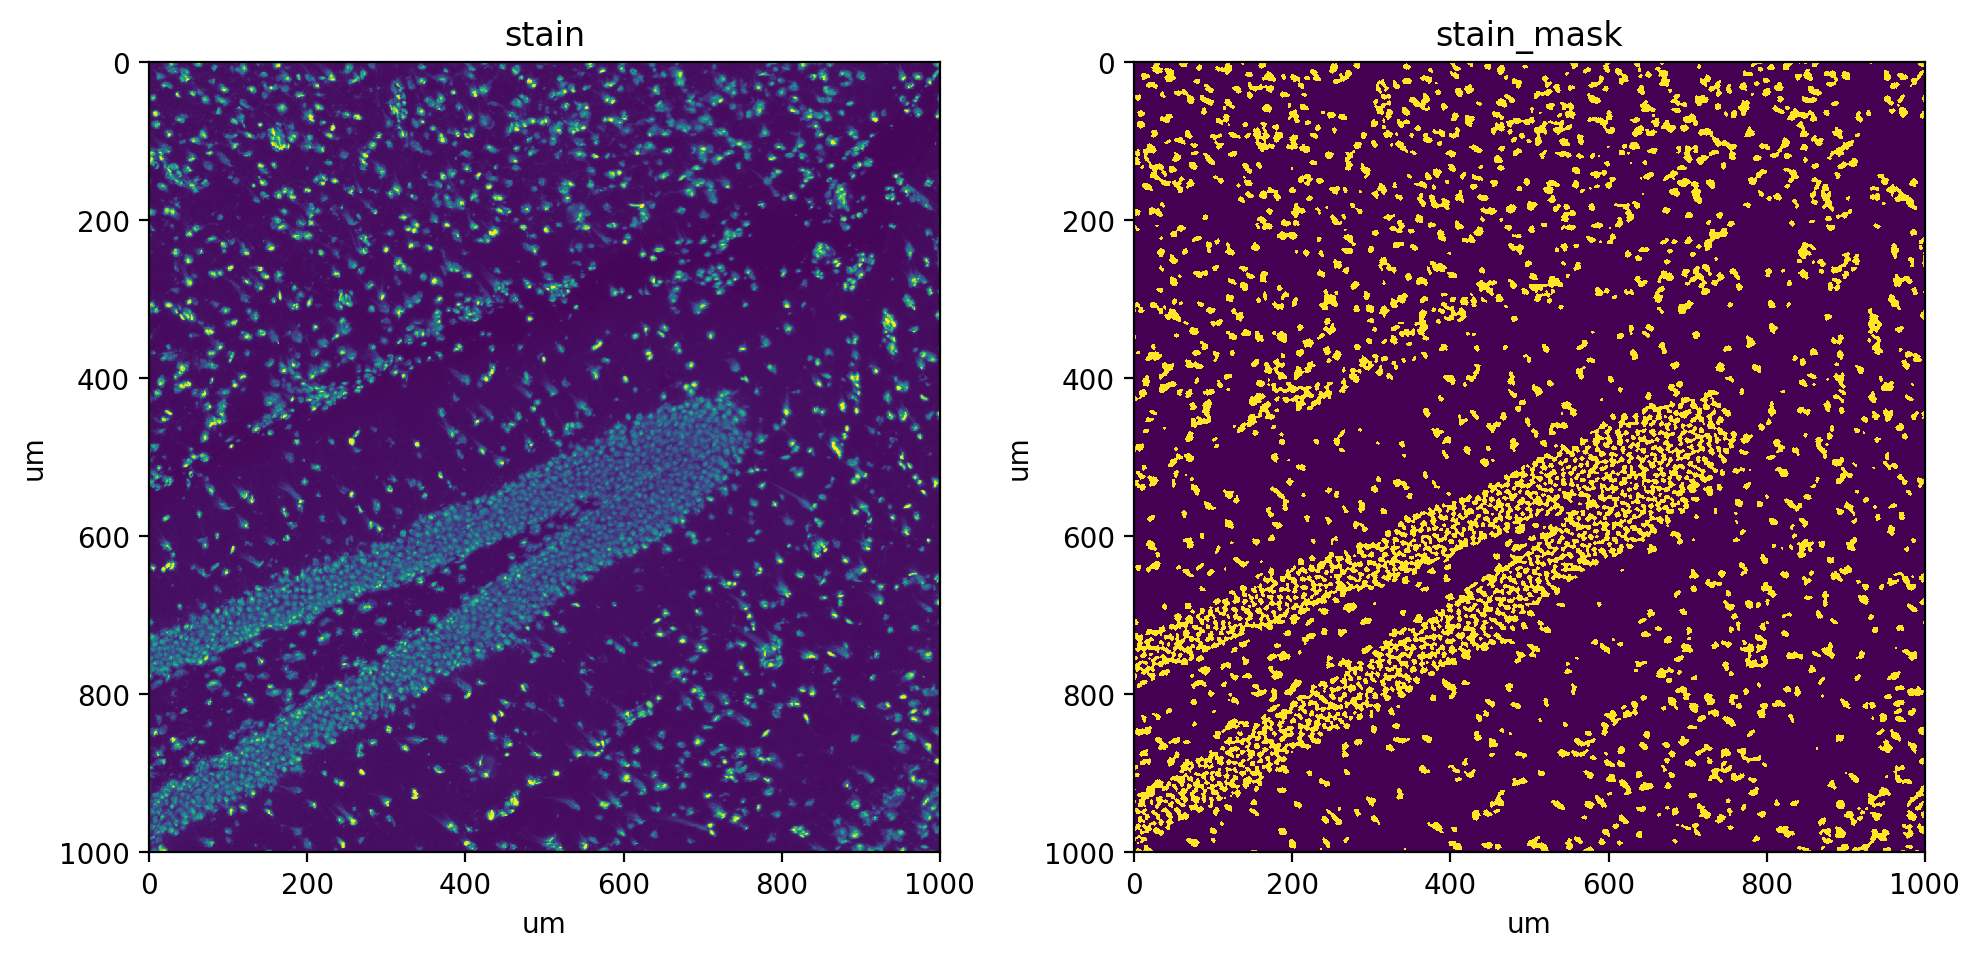

In [3]:
st.pp.segmentation.mask_nuclei_from_stain(adata)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain', ax=axes[0])
st.pl.imshow(adata, 'stain_mask', ax=axes[1])

### 1.2. Mask nuclei from unspliced RNA

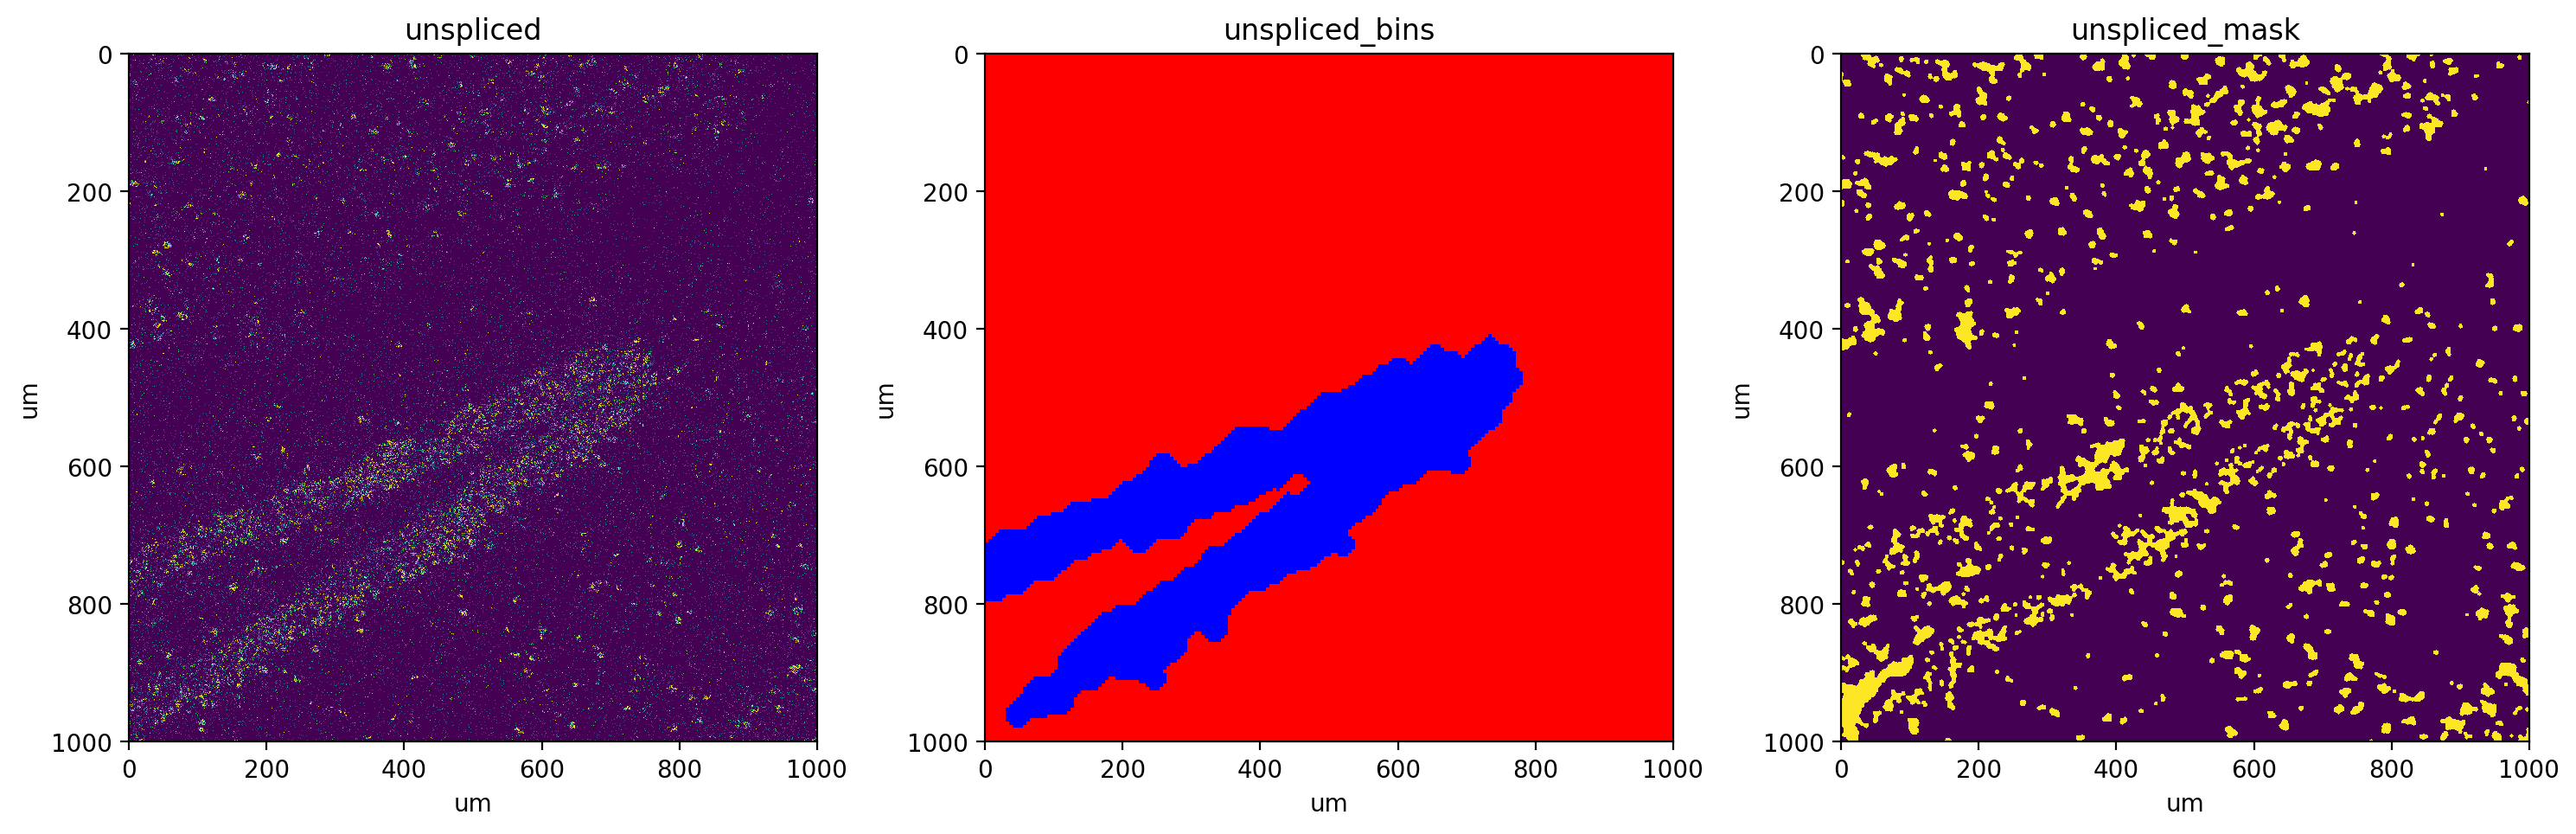

In [4]:
st.pp.segmentation.segment_densities(adata, 'unspliced', 10, k=7, dk=5, distance_threshold=5, background=False)
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022),
    bp_kwargs=dict(n_threads=8, p=0.7, q=0.3),
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced', ax=axes[0], vmax=5)
st.pl.imshow(adata, 'unspliced_bins', ax=axes[1], labels=True)
st.pl.imshow(adata, 'unspliced_mask', ax=axes[2])

### 1.3. Alignment

When we superimpose the two masks, we observe this minor mis-alignment. The staining image should move slightly to the right.

Text(0.5, 1.0, 'superimposed stain_mask and unspliced_mask')

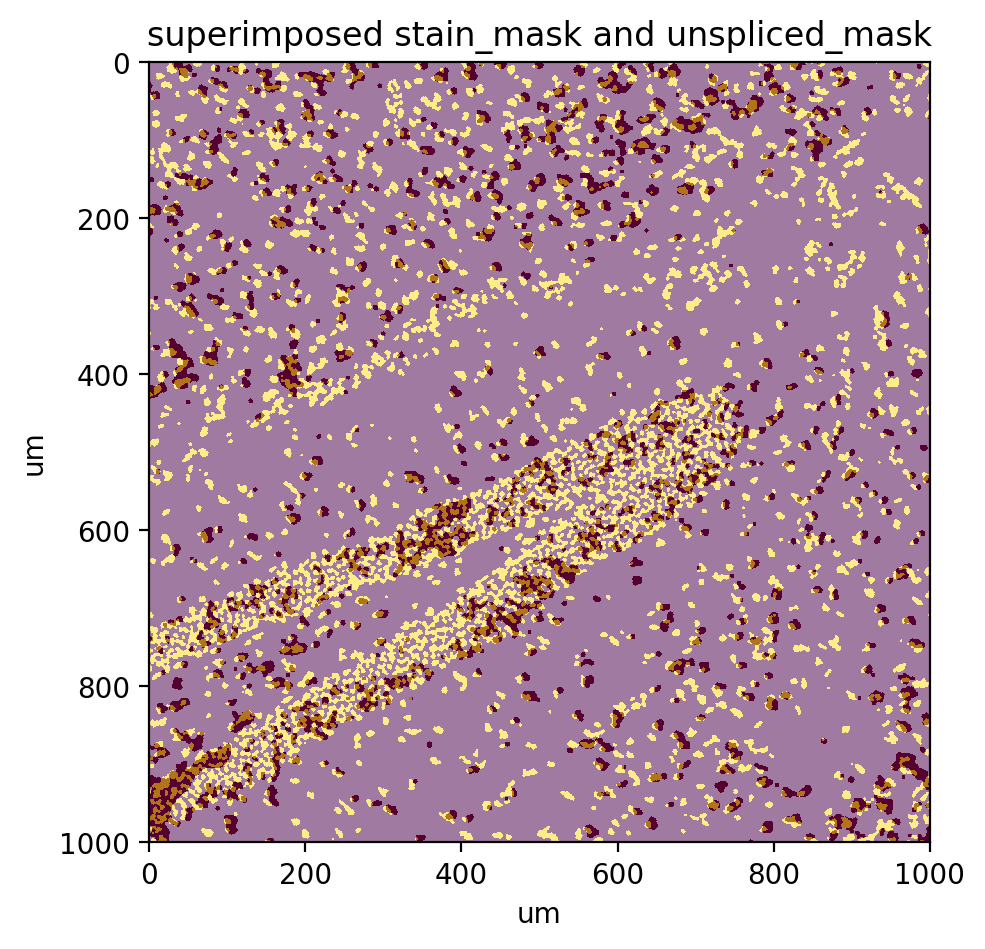

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_mask', ax=ax)
st.pl.imshow(adata, 'unspliced_mask', ax=ax, alpha=0.5, cmap='Reds')
ax.set_title('superimposed stain_mask and unspliced_mask')

Loss 0.3187: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Text(0.5, 1.0, 'superimposed stain_mask and unspliced_mask')

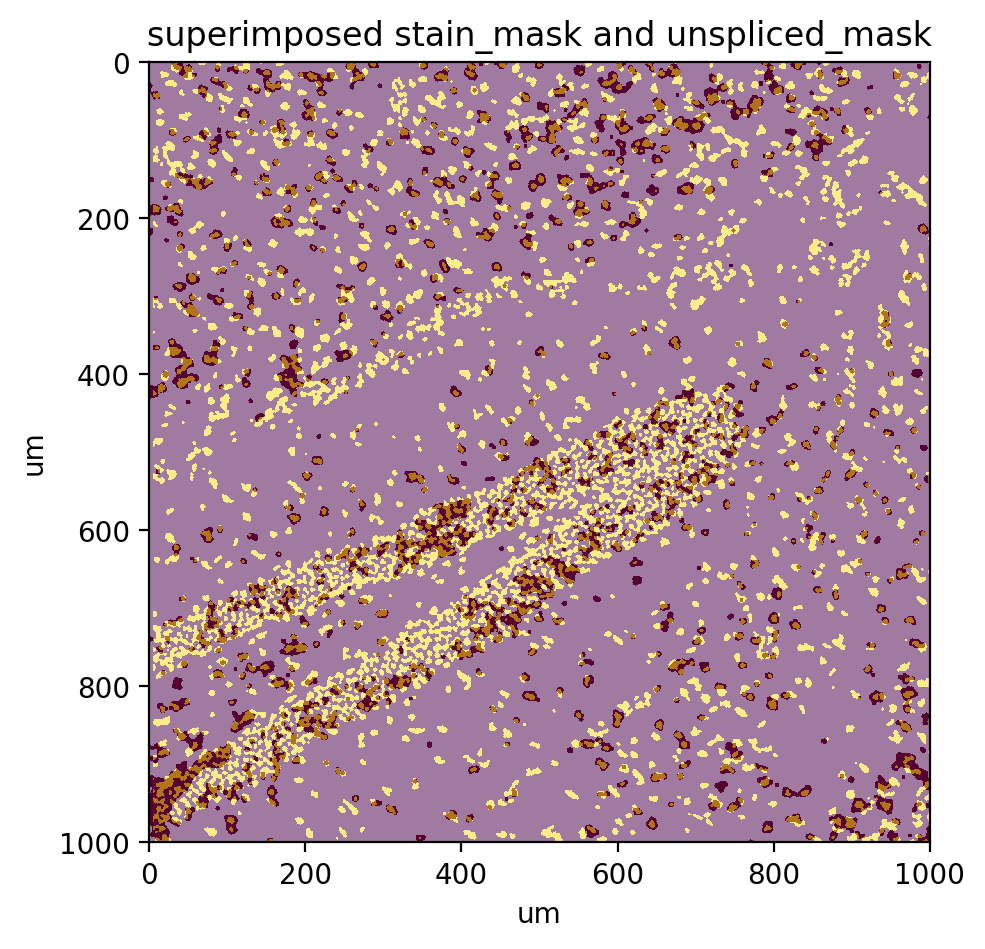

In [6]:
# `transform_layers` specifies which layers should be transformed based on the final affine transformation.
# These layers will be overwridden.
st.pp.segmentation.refine_alignment(adata, transform_layers=['stain', 'stain_mask'])

fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_mask', ax=ax)
st.pl.imshow(adata, 'unspliced_mask', ax=ax, alpha=0.5, cmap='Reds')
ax.set_title('superimposed stain_mask and unspliced_mask')

We can also take a look at the actual affine transformation matrix.

In [7]:
theta = adata.uns['spatial']['alignment']['theta']
scale = theta[0, 0], theta[1, 1]
shear = theta[0, 1], theta[1, 0]
translate = tuple(theta[:,2] * adata.shape)  # Multiply shape because this is normalized

print(scale, shear, translate)

(0.999415, 0.9991937) (0.00066496746, -0.00031188407) (-21.088484801352024, 5.521950864465907)


## 2. Label nuclei

Once we have a mask of nuclei, we will attempt to label each individual nuclei using the Watershed algorithm, which consists of first finding Watershed markers that will serve as the starting points of the Watershed algorithm. Then, using these markers, we run Watershed.

Note that this point onward, we will not be using the unspliced RNA-based mask.

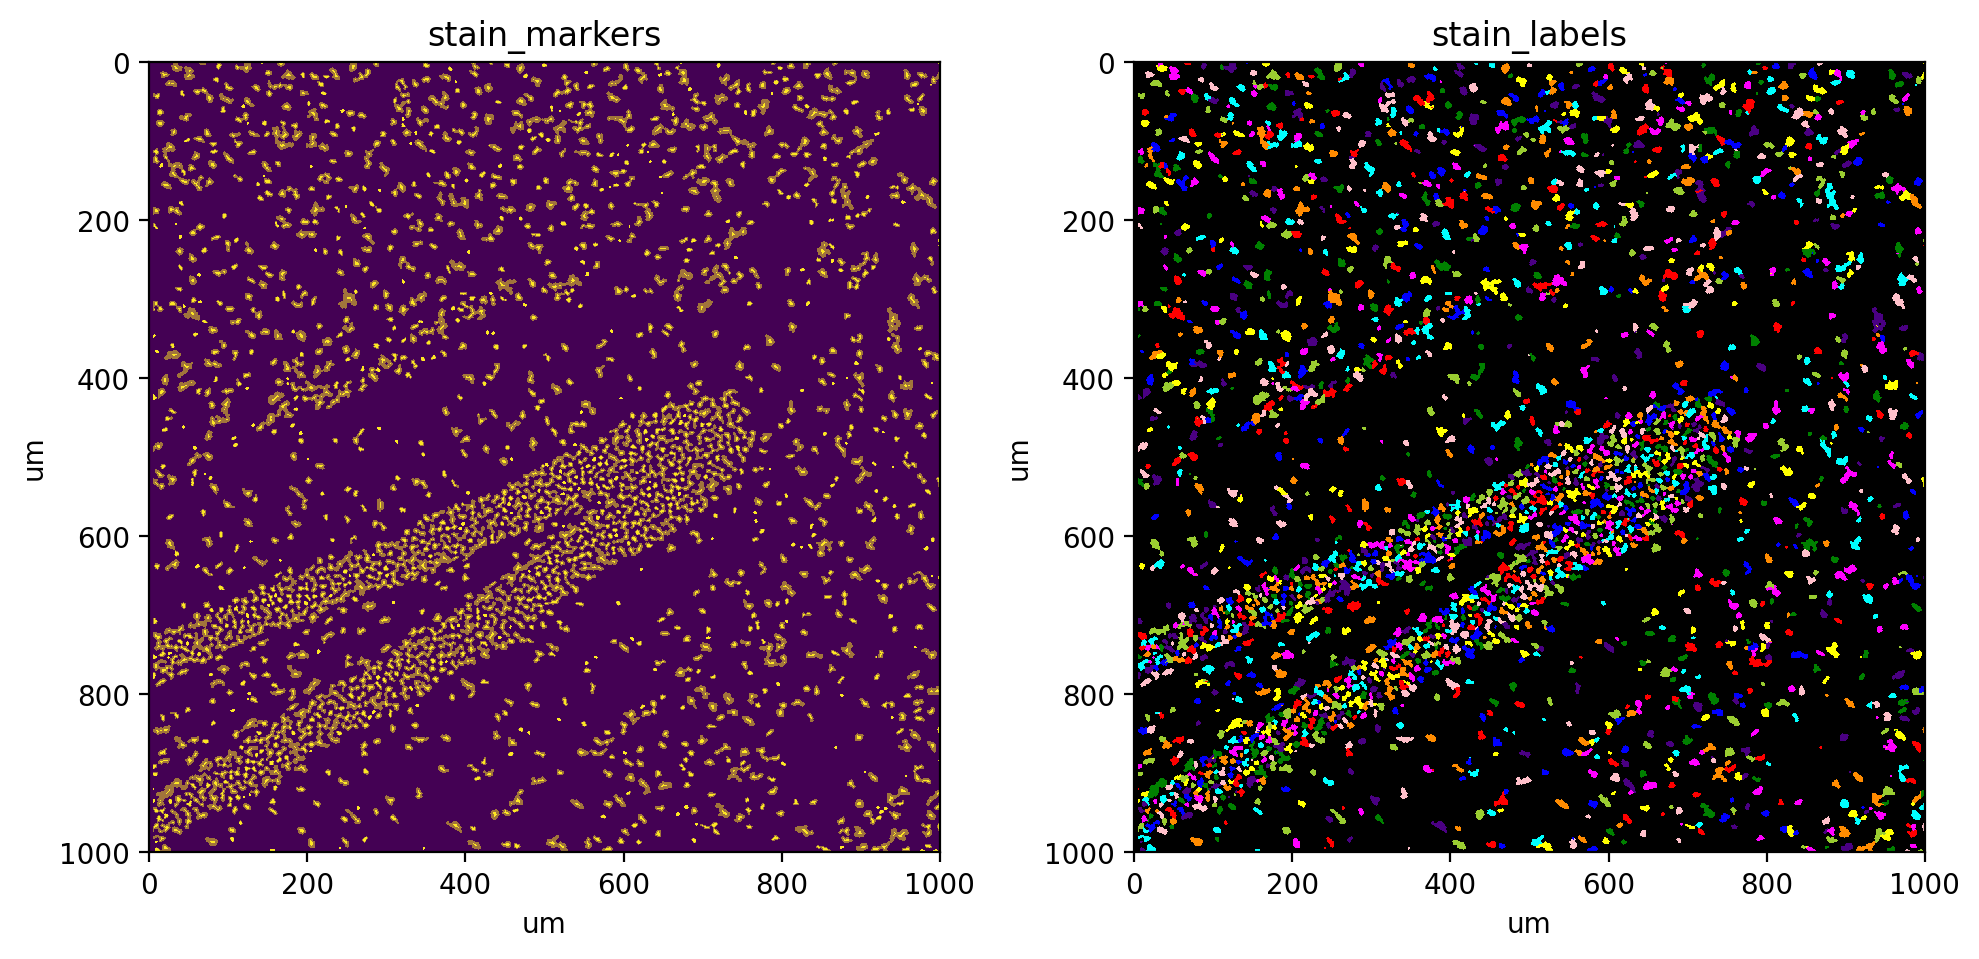

In [8]:
st.pp.segmentation.watershed_markers(adata)
st.pp.segmentation.watershed(adata)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_mask', ax=axes[0])
st.pl.imshow(adata, 'stain_markers', ax=axes[0], alpha=0.5)

st.pl.imshow(adata, 'stain_labels', ax=axes[1], labels=True)

## 3. Expand nuclei to cells

The nuclei labels obtained above are labeled with high confidence. However, it is also possible to expand these labels into regions that we believe to be the cytoplasm. There are a few approaches.

1. Naively expand each of the nuclei labels by a certain distance.
2. Use the fact that ssDNA has low (but non-zero) affinity to cytoplasmic RNA. Therefore, we can obtain a "cell"/"cytoplasm" mask by thresholding the image with a more lenient global threshold. Then, we can run Watershed again, but this time with the nuclei lables as the starting markers.
3. Use total RNA signal to estimate regions that are likely to be cytoplasmic. Using this as our new mask, run Watershed again.

### 2.1. Naive expansion

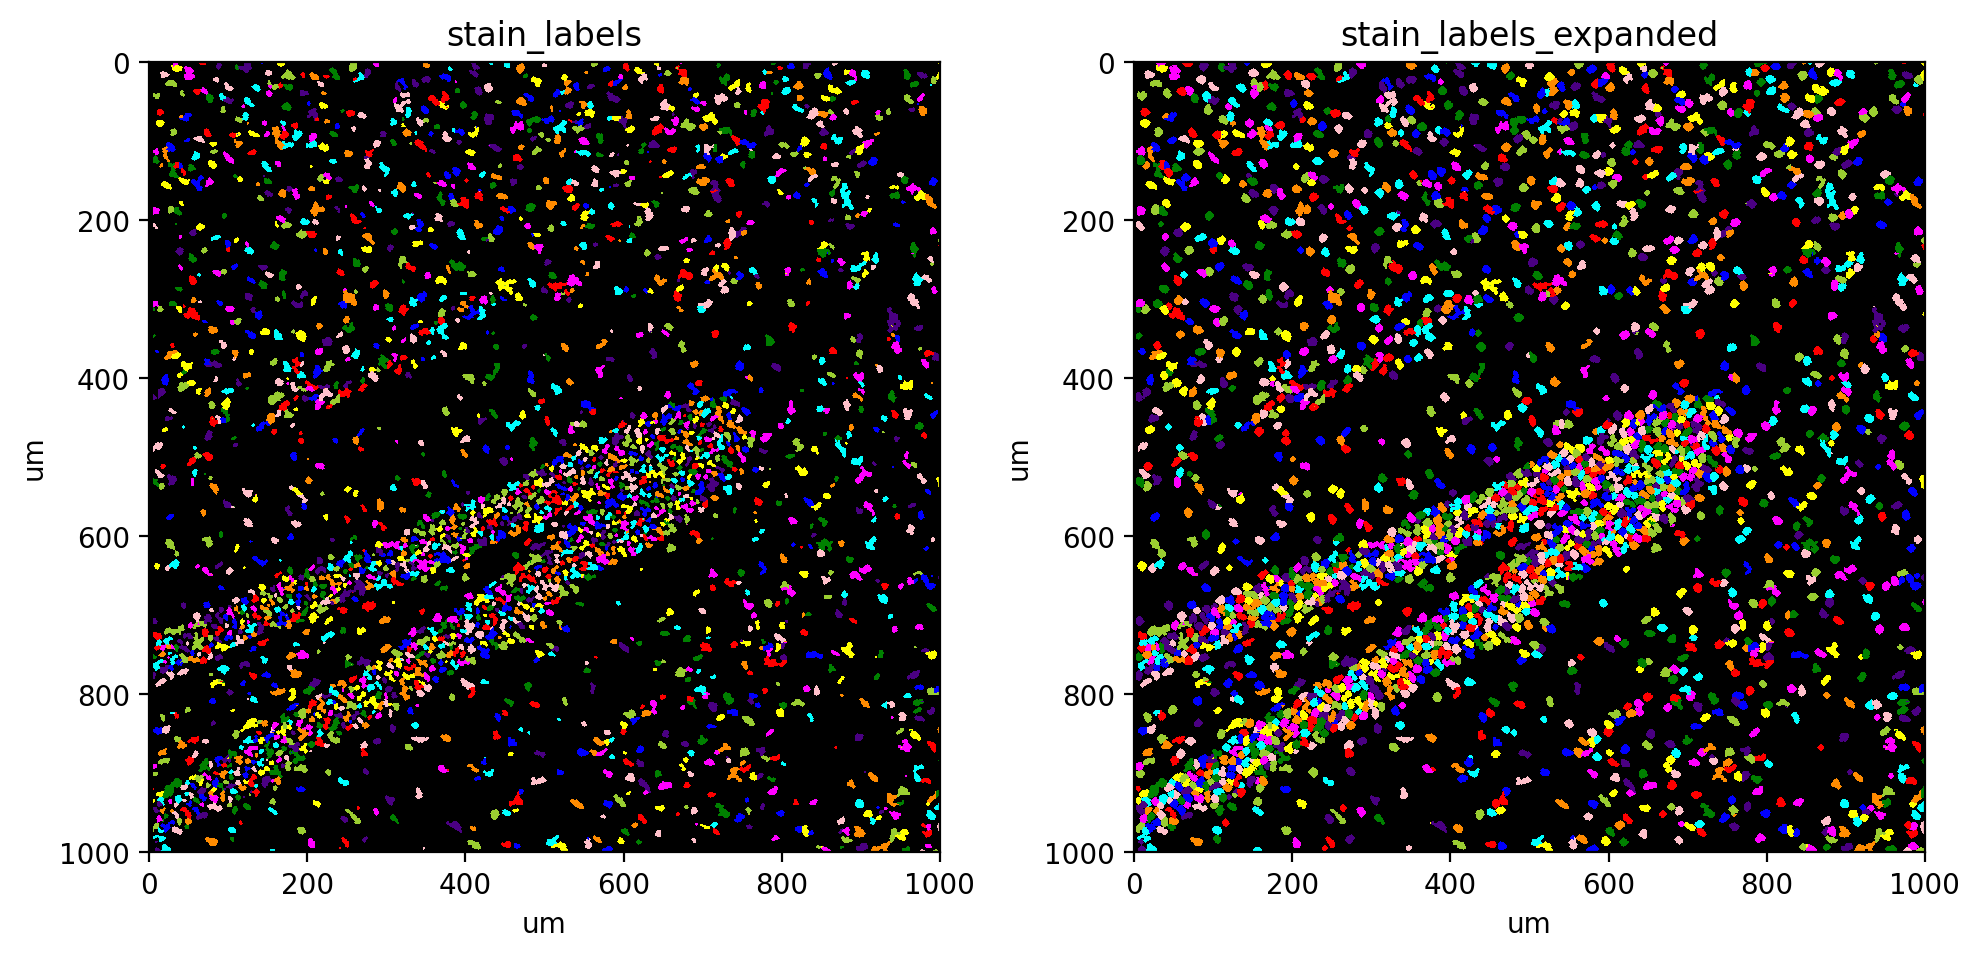

In [9]:
st.pp.segmentation.expand_labels(adata, 'stain', distance=5, max_area=400)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_labels', ax=axes[0], labels=True)
st.pl.imshow(adata, 'stain_labels_expanded', ax=axes[1], labels=True)

### 2.2. Thresholding + Watershed

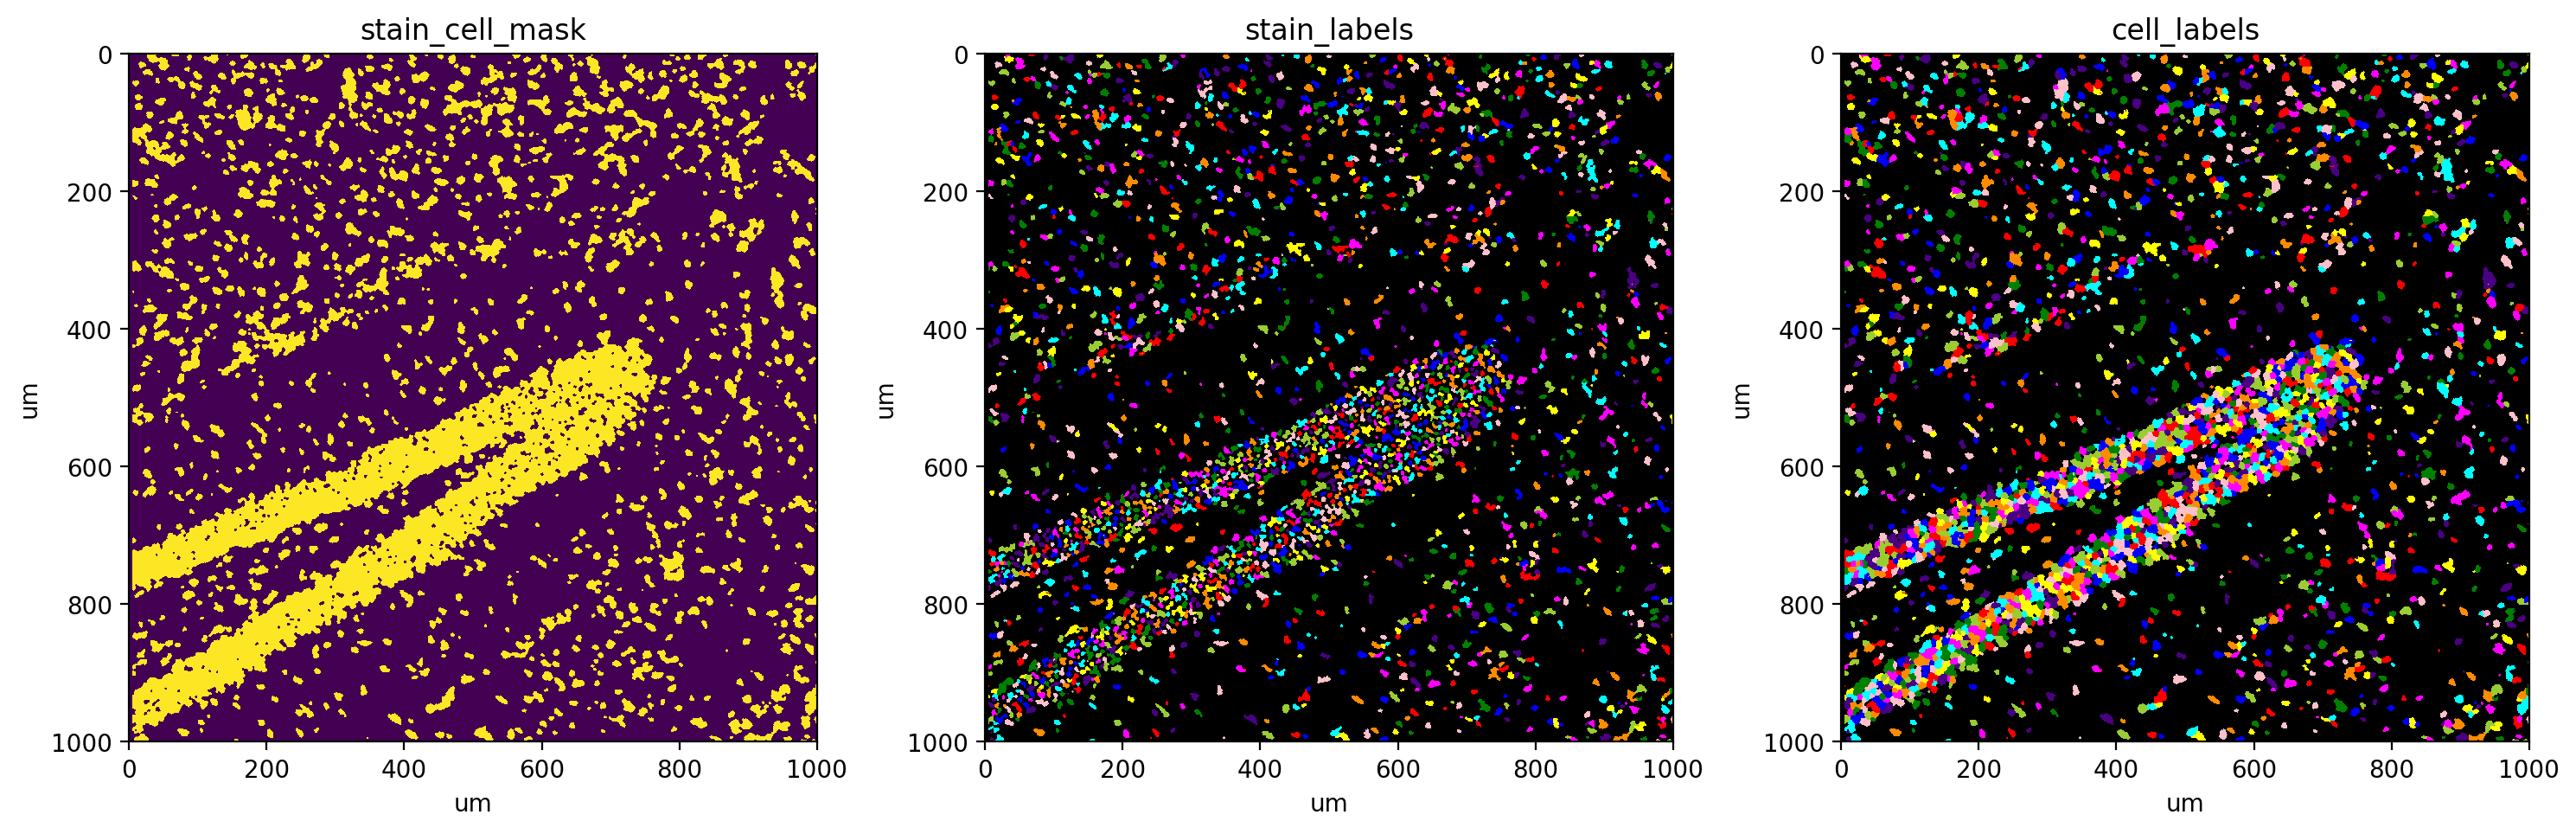

In [10]:
st.pp.segmentation.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.pp.segmentation.watershed(
    adata,
    'stain',
    mask_layer='stain_cell_mask',
    markers_layer='stain_labels',
    out_layer='cell_labels',
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_cell_mask', ax=axes[0])
st.pl.imshow(adata, 'stain_labels', ax=axes[1], labels=True)
st.pl.imshow(adata, 'cell_labels', ax=axes[2], labels=True)

In [11]:
# This is what we will be using for all benchmarks
adata.write('data/stain_segmentation.h5ad', compression='gzip')

### 2.3. Estimation + Watershed

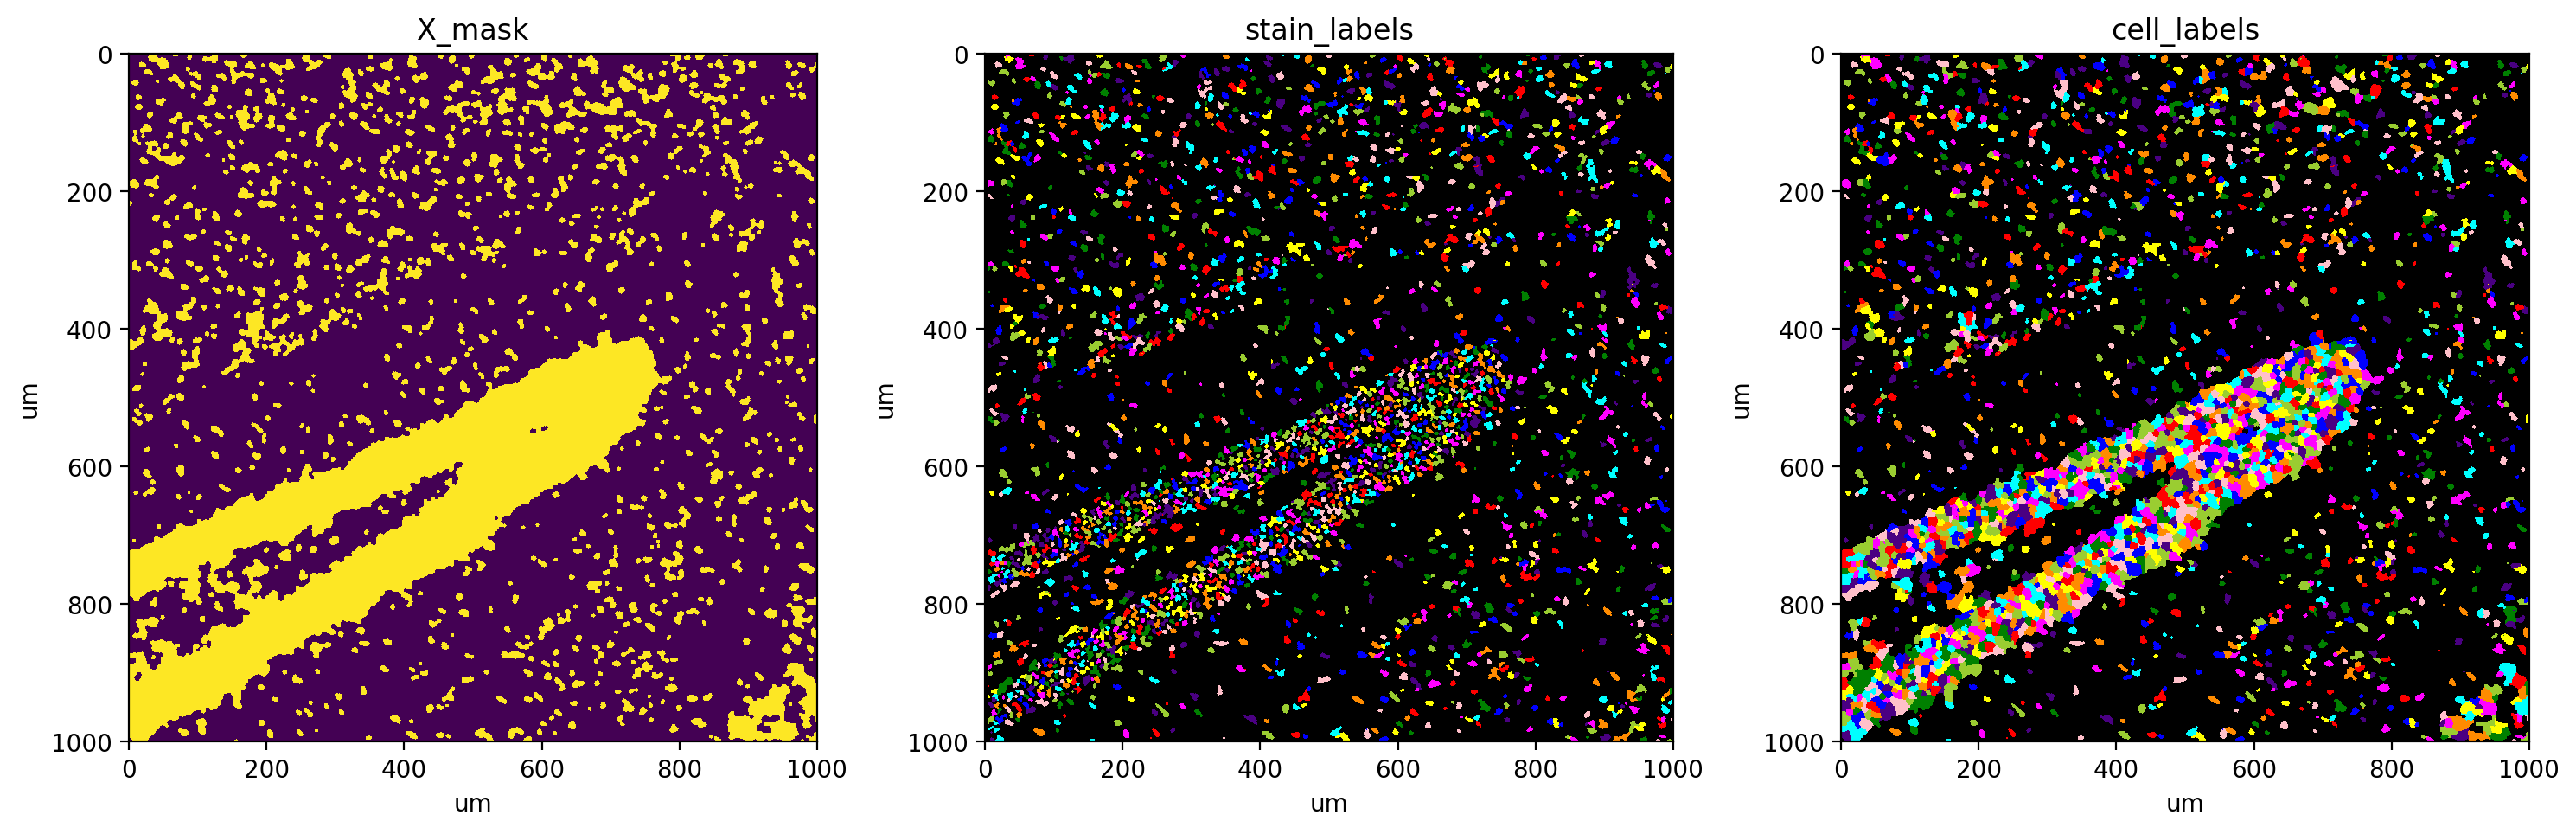

In [12]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=15, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.9, q=0.1),
    certain_layer='stain_labels'
)
st.pp.segmentation.watershed(
    adata,
    'stain',
    mask_layer='X_mask',
    markers_layer='stain_labels',
    out_layer='cell_labels',
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'X_mask', ax=axes[0])
st.pl.imshow(adata, 'stain_labels', ax=axes[1], labels=True)
st.pl.imshow(adata, 'cell_labels', ax=axes[2], labels=True)